### Planck Hotspot Search
This notebook searches for hotspots in the Planck PR4 temperature maps. Note that we must run ```planck_pr4_compsep.py soubhik {TILE}``` for each tile before we use this notebook.

In [1]:
## Imports
%pylab inline
import szifi
import healpy as hp

## Directories
output_dir = '/insomnia001/home/lha2126/szifi_hotspot/E_outputs_planck/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Load Szifi

In [2]:
### DEFAULT PARAMETERS
params_szifi = szifi.params_szifi_default
params_data = szifi.params_data_default
params_model = szifi.params_model_default

# Data paths
params_szifi['path'] = '/insomnia001/home/lha2126szifi_hotspot/' # main code
params_data["field_ids"] = []
params_data['data_set'] = 'Planck_pr4_compsep_E_data' # specifies szifi settings for the beam (experiment dependent)

# Load cosmology parameters
import camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.32, ombh2=0.022383, omch2=0.12011,tau=0.0543,mnu=0.06,omk=0,standard_neutrino_neff=True)
back = camb.get_background(pars)
eta_rec = back.tau_maxvis # comoving horizon at last-scattering
eta_0 = back.tau0 # comoving horizon today
chi_rec = eta_0-eta_rec # distance to comoving horizon

# Define range of template parameters
theta_500 = np.geomspace(0.5,15.,15) # theta500 (only used for tSZ)
all_eta_star = np.geomspace(10,1000,10) # eta_* in Mpc

# Define collapsed 1D grids of eta_* and eta_HS
eta_stars = []
eta_hss = []
for i in range(len(all_eta_star)):
    # Ensure that the hotspot is at the right distance
    chi_HSs = np.linspace(max(chi_rec-all_eta_star[i],0),min(chi_rec+all_eta_star[i],eta_0),12)[1:-1]
    eta_HSs = eta_0-chi_HSs
    for j in range(len(eta_HSs)):
        eta_stars.append(all_eta_star[i])
        eta_hss.append(eta_HSs[j])
eta_stars = np.asarray(eta_stars)
eta_hss = np.asarray(eta_hss)

# Load into szifi parameters
params_szifi['theta_500_vec_arcmin'] = theta_500
params_szifi['eta_star_vec'] = eta_stars
params_szifi['eta_hs_vec'] = eta_hss

# Some other options
params_szifi['iterative'] = False
params_szifi['lrange'] = [30,3000]

# Other parameters
params_szifi['inpaint'] = True
params_szifi['deproject_cib'] = None
params_szifi['estimate_spec'] = 'estimate'
params_szifi['save_coupling_matrix'] = True

# SNR threshold to consider a preliminary "detection"
params_szifi['q_th'] = 4.0
params_szifi['q_th_noise'] = 4.0
params_szifi['freqs'] = []

data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

TypeError: 'float' object cannot be interpreted as an integer

### Plot the data and mask

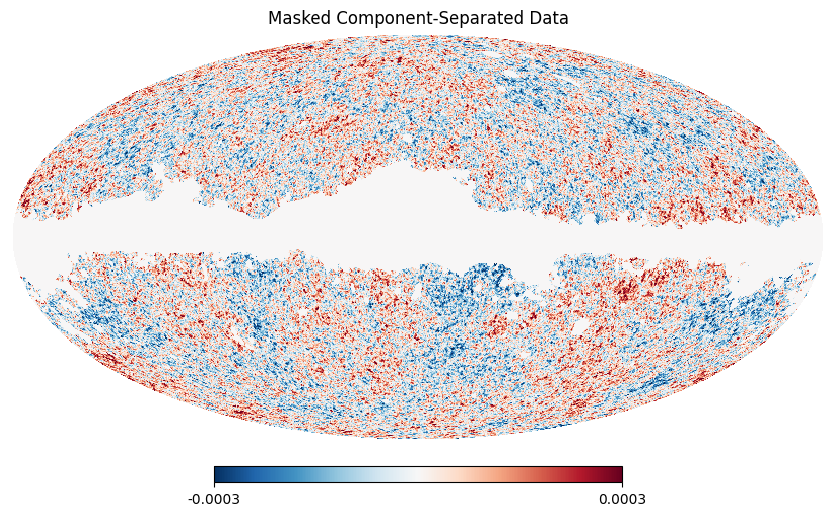

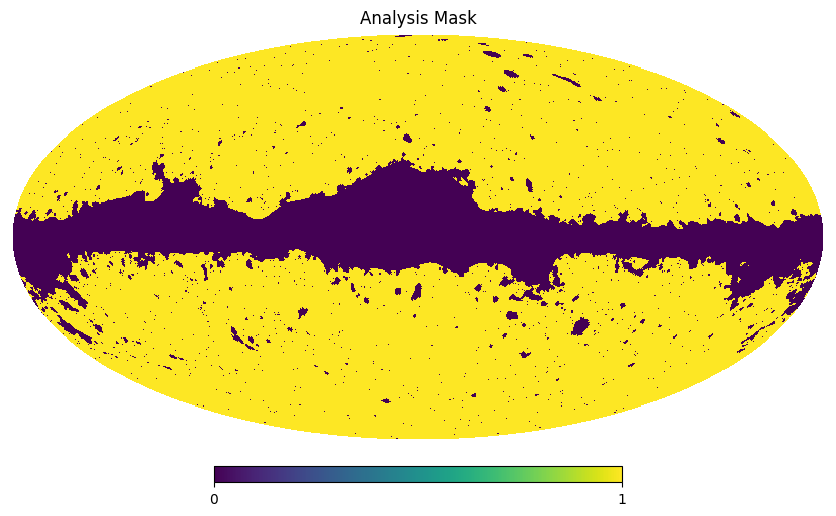

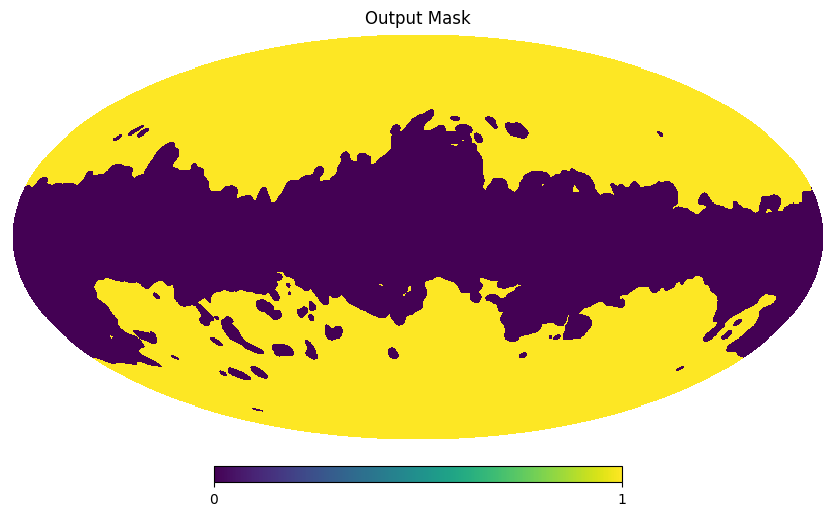

In [74]:
### Raw temperature data
obs = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/sevem/SEVEM_NPIPE_2019/npipe6v20_sevem_cmb_005a_2048.fits')
### Analysis masks (temperature)
# Standard mask
mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')
# Extra inpainting mask (not used for point detection)
inp_mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-Inpainting-Mask-Int_2048_R3.00.fits')
### Output mask 
# We use a more conservative mask to evaluate detections
# This is the same masked used in tSZ cluster searches
sz_mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_Compton-SZMap_2048_R2.00.fits')

hp.mollview(mask*obs, max=0.0003, min=-0.0003, cmap=cm.RdBu_r, title='Masked Component-Separated Data')
hp.mollview(mask,title='Analysis Mask')
hp.mollview(sz_mask, title='Output Mask')

### Load hotspots

In [75]:
def load_png_catalog():
    """Load a hotspot catalog from file, combining all tiles present."""
    i = 0
    for batch in range(768):
        name = output_dir+'planck_sep_batch%d_soubhik.npy'%(batch)
        try:
            if i==0:
                if 'eta_star' in np.load(name,allow_pickle=True).item().catalogue.keys():
                    tot_cat = np.load(name,allow_pickle=True).item()
                    i += 1
                else:
                    continue
            else:
                try:
                    tot_cat.append(np.load(name,allow_pickle=True).item())
                except KeyError:
                    pass;
                i += 1
        except IOError:
            #print(batch)
            continue
    if i!=0:
        print("Found %d PNG hotspots (SNR>4) from %d catalogues"%(len(tot_cat.catalogue['q_opt']),i))
    else:
        raise Exception("No catalogs found")
    return tot_cat

# Cut to SNR of 5
snr_min = 5
png_cat = szifi.get_catalogue_q_th(load_png_catalog(), snr_min)

Found 8035 PNG hotspots (SNR>4) from 768 catalogues


### Useful Functions

In [58]:
def remove_point_sources(input_cat, exclusion_factor=5):
    """Given a 6-frequency point-source catalog (point_cat), remove any hotspot candidates within 5*FWHM of the point-sources.""" 
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        bad = False
        for f in range(6):
            theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians

            cdis = hp.rotator.angdist((clon,clat),(point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat']),lonlat=True)
            if np.min(cdis)<exclusion_factor*theta_beam: bad=True

        if not bad:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def remove_cat(input_cat, removal_cat, dis_arcmin=10):
    """"Remove any hotspot candidates within 10' of sources in another catalog."""
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        cdis = hp.rotator.angdist((clon,clat),(removal_cat['lon'],removal_cat['lat']),lonlat=True)
        if not np.min(cdis)<dis_arcmin*np.pi/180./60.:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def cut_on_map(input_cat, mask_map):
    """Remove any hotspot candidates that are outside the mask of interest"""
    return szifi.cat.get_catalogue_indices(input_cat, np.where(mask_map[hp.ang2pix(2048,input_cat.catalogue['lon'],input_cat.catalogue['lat'],lonlat=True)]))

def merge_cat(catalogue, size_factor=0.2,verb=True):
    """Merge catalogs together combining overlapping sources."""
    len_pre = np.inf
    len_post = -1
    it = 0
    while len_pre!=len_post: 
        len_pre = len(catalogue.catalogue['q_opt'])
        catalogue = _merge_cat(catalogue, size_factor=size_factor, verb=verb)
        len_post = len(catalogue.catalogue['q_opt'])
        it +=1
    print('Finished in %d iterations'%it)
    return catalogue

def _merge_cat(catalogue,size_factor=0.2,verb=True):
    catalogue = szifi.cat.get_catalogue_indices(catalogue,np.where(catalogue.catalogue["q_opt"] != -1.)[0])
    n_clusters = len(catalogue.catalogue["q_opt"])
    catalogue_merged = szifi.cat.cluster_catalogue()
    catalogue_compare = catalogue

    i = 0

    indices_subtract = np.arange(len(catalogue_compare.catalogue["q_opt"]))
    merge_flags = np.zeros(0)

    while len(indices_subtract) > 0:
        catalogue_compare_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():
            if len(catalogue_compare.catalogue[key]) > 0.:
                catalogue_compare_new.catalogue[key] = catalogue_compare.catalogue[key][indices_subtract]

        catalogue_compare = catalogue_compare_new

        n_clusters = len(catalogue_compare.catalogue["q_opt"])
        dist = szifi.sphere.get_angdist(catalogue_compare.catalogue["lon"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lon"],
        catalogue_compare.catalogue["lat"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lat"])
        
        dist_thresh = np.sqrt(4.*np.pi)*size_factor*(catalogue_compare.catalogue['eta_star'][0]+catalogue_compare.catalogue['eta_star'])/eta_0
        indices = np.where(dist <= dist_thresh)[0]
        merge_flags = np.append(merge_flags,len(indices))
        
        index_max = indices[np.argmax(catalogue_compare.catalogue["q_opt"][indices])]
        catalogue_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():
            if len(catalogue_compare.catalogue[key]) > 0.:
                catalogue_new.catalogue[key] = np.array([catalogue_compare.catalogue[key][index_max]])

        catalogue_merged.append(catalogue_new,append_keys="new")
        indices_subtract = np.setdiff1d(np.arange(len(catalogue_compare.catalogue["q_opt"])),indices)
        
        i += 1

    if verb: print("Start size: %d, end size: %d"%(len(catalogue.catalogue['q_opt']),len(catalogue_merged.catalogue['q_opt'])))
    return catalogue_merged

### Process the hotspot catalog
Here we'll combine together the overlapping candidates and make various cuts based on the mask. We can optionally remove sources too close to known point-sources or tSZ clusters. For this, we can run a full frequency search for point-sources and/or tSZ clusters (using a modified version of the planck_pr4_analysis script). 

In [59]:
def process_png(_png_cat, merge_factor=0.2, point_exclusion_factor=5, sz_radius=10):
    """Process a PNG catalogue, applying various cuts"""
    
    print("\nStarted with %d PNG hotspots"%len(_png_cat.catalogue['q_opt']))
    
    # Apply the output mask
    png_cat = cut_on_map(_png_cat, sz_mask)
    print("Found %d PNG hotspots after output mask cut"%len(png_cat.catalogue['q_opt']))
    
    # Remove nearby point-sources
    try:
        png_cat = remove_point_sources(png_cat, exclusion_factor=point_exclusion_factor)
        print("Found %d PNG hotspots after point-source cut"%len(png_cat.catalogue['q_opt']))
    except NameError:
        print("No point-source cut!")
        pass
    
    # Remove SZ sources
    try:    
        png_cat = remove_cat(png_cat, sz_cat_nopoint.catalogue, dis_arcmin=sz_radius)
        print("Found %d PNG hotspots after SZ-source cut"%len(png_cat.catalogue['q_opt']))
    except NameError:
        print("No SZ-source cut!")
        pass
        
    # # Remove official Planck SNR>5 SZ sources
    # png_cat = remove_cat(png_cat, sz_official, dis_arcmin=sz_radius)
    # print("Found %d PNG hotspots after official SZ-source cut"%len(png_cat.catalogue['q_opt']))

#     # Remove component-separated mask
#     png_cat = cut_on_map(png_cat, compsep)
#     print("Found %d PNG hotspots after component-separation map cut"%len(png_cat.catalogue['q_opt']))
    
#     # Remove inpainting mask
#     png_cat = cut_on_map(png_cat, inp_mask)
#     print("Found %d PNG hotspots after inpainting mask cut"%len(png_cat.catalogue['q_opt']))
    
#     # Remove point mask
#     png_cat = cut_on_map(png_cat, point_mask)
#     print("Found %d PNG hotspots after point mask cut"%len(png_cat.catalogue['q_opt']))

    # Remove non-thermal sources
    # png_cat = remove_cat(png_cat, nt_official, dis_arcmin=sz_radius)
    # print("Found %d PNG hotspots after non-thermal source cut"%len(png_cat.catalogue['q_opt']))
  
    # Merge sources
    #png_cat = szifi.merge_detections(png_cat,radius_arcmin=merge_radius,return_merge_flag=False,mode="closest")
    png_cat = merge_cat(png_cat,size_factor=merge_factor, verb=False)
    print("Found %d merged PNG hotspots"%len(png_cat.catalogue['q_opt']))
    
    # Return
    return png_cat

png_cat_proc = process_png(png_cat, merge_factor=0.5, point_exclusion_factor=5, sz_radius=10)


Started with 372 PNG hotspots
Found 87 PNG hotspots after output mask cut
No point-source cut!
No SZ-source cut!
Finished in 2 iterations
Found 49 merged PNG hotspots


### Plot the Hotspot Candidates

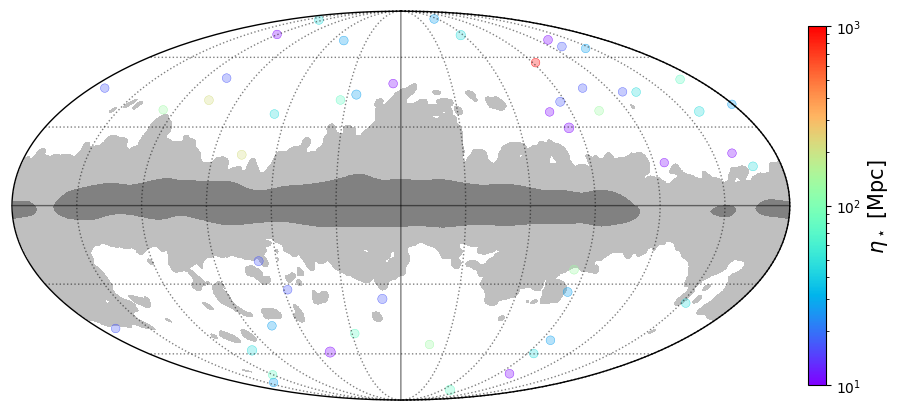

In [61]:
gal90 = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=5)

# sz_cut = np.zeros(len(sz_mask),dtype=float)
sz_cut[gal90==0] = 50
sz_cut[(sz_mask==0)*(gal90!=0)] = 25
hp.mollview(sz_cut+gal90,max=100, #coord=["G", "E"],
            cmap=cm.gray_r,cbar=False,notext=True,title='')
hp.graticule(dpar=30.,dmer=30.,alpha=0.5)

cval = np.log10(png_cat_proc.catalogue['eta_star'])
hp.projscatter(png_cat_proc.catalogue['lon'],
               png_cat_proc.catalogue['lat'],
               #coord=["G", "E"],
               facecolor='none',
               edgecolor=cm.rainbow((cval-cval.min())/(cval.max()-cval.min())),
               lw=0.3,alpha=0.9,
               s=png_cat_proc.catalogue['q_opt']**2*1.5,
               lonlat=True)#,marker='o',linewidths=0.01,ls='')#,c='r')
hp.projscatter(png_cat_proc.catalogue['lon'],
               png_cat_proc.catalogue['lat'],
               #coord=["G", "E"],
               facecolor=cm.rainbow((cval-cval.min())/(cval.max()-cval.min())),
               edgecolor='none',
               lw=0.3,alpha=0.3,
               s=png_cat_proc.catalogue['q_opt']**2*1.5,
               lonlat=True)
plt.scatter(-1+0.*cval,-1+0.*cval,c=10**cval,s=0,cmap=cm.rainbow,norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(fraction=0.022, pad=0.02)
#cbar.set_ticks(10,1000)
cbar.set_label(r'$\eta_\star$ [$\mathrm{Mpc}$]',fontsize=15);
#plt.savefig('pub_plots/detections_scatter.pdf',bbox_inches='tight')

### Plot the good candidates (red) and the raw candidates (blue)

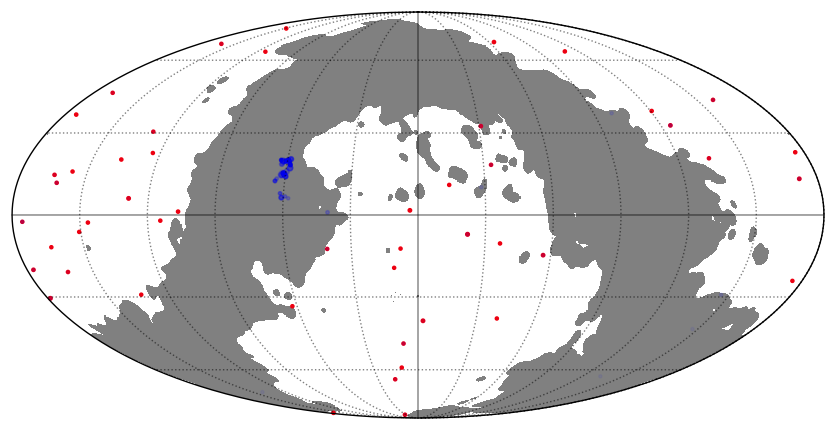

In [63]:
sz_cut = np.zeros(len(sz_mask),dtype=float)
sz_cut[sz_mask==0] = np.nan
hp.mollview(sz_cut,max=100, coord=["G", "E"],cmap=cm.gray_r,cbar=False,notext=True,title='')
ss = 5
hp.graticule(dpar=30.,dmer=30.,alpha=0.5)
hp.projscatter(png_cat_proc.catalogue['lon'][png_cat_proc.catalogue['q_opt']>ss],
               png_cat_proc.catalogue['lat'][png_cat_proc.catalogue['q_opt']>ss],
               coord=["G", "E"], s=png_cat_proc.catalogue['q_opt'][png_cat_proc.catalogue['q_opt']>ss]**2/ss,lonlat=True,c='r')
hp.projscatter(png_cat.catalogue['lon'][png_cat.catalogue['q_opt']>ss],
               png_cat.catalogue['lat'][png_cat.catalogue['q_opt']>ss],
               coord=["G", "E"], s=png_cat.catalogue['q_opt'][png_cat.catalogue['q_opt']>ss]**2/ss,lonlat=True,c='b',alpha=0.05)
#hp.projscatter(nt_official['lon'],nt_official['lat'],s=3,lonlat=True)

### Histogram the outputs

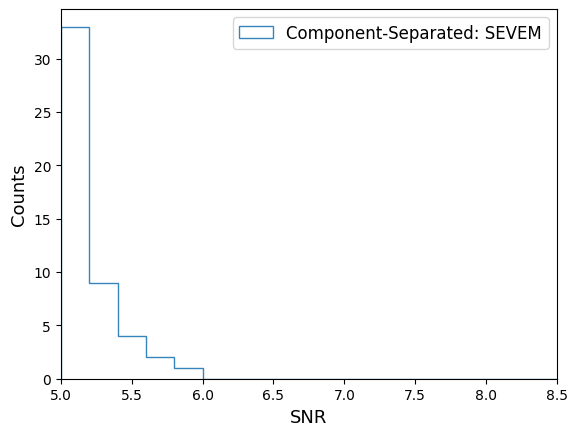

In [65]:
plt.hist(png_cat_proc.catalogue['q_opt'],label=r'Component-Separated: SEVEM',alpha=0.9,bins=50,range=[5,15],histtype='step')
plt.legend(fontsize=12);
plt.xlim(5,8.5)
plt.xlabel(r'SNR',fontsize=13);
plt.ylabel(r'Counts',fontsize=13);
#plt.savefig('pub_plots/detections_pdf.pdf',bbox_inches='tight')

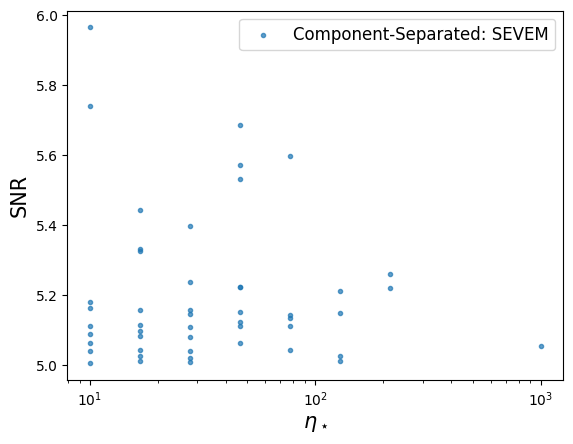

In [67]:
plt.scatter(png_cat_proc.catalogue['eta_star'],png_cat_proc.catalogue['q_opt'],marker='.',alpha=0.7,label=r'Component-Separated: SEVEM')
plt.xscale('log')
plt.xlabel(r'$\eta_\star$',fontsize=15)
plt.ylabel(r'SNR',fontsize=15);
plt.legend(fontsize=12);